In [1]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool
from torch_geometric.datasets import QM9
from torch_geometric.utils import degree, add_self_loops
from matplotlib import pyplot as plt

# Exercise Sheet 09

## Exercise 1

Representation in KineticNet:
Here the irreducible representation of $\mathrm{SO}(3)$ is used. The features inside the network transform according to the Wigner-D matrices.

Representation in M-OFDFT:
Invariance inside the network after applying the local frames transformations. Because of this tranformation, the features inside the network do not change anymore under rotations.

## Exercise 2
In this exercise, you’ll implement a simple Graph Convolutional Layer and train your model using real
chemistry data. The aim is to try to predict the electronic ground state energy of diverse molecules
using only the atom types and their “ball-and-stick” connectivity as input. You will use the QM9 dataset,
which consists of molecular structures with up to 9 heavy atoms, with labels calculated at DFT-level
accuracy.

### (a)
Use the pytorch-geometric library to load the QM9 dataset. Create a DataLoader object for
training, validation, and testing. Use 2000 samples for training and 500 samples each for validation
and testing.

In [8]:
# Load QM9 dataset
dataset = QM9(root='data/QM9')

target_idx = 7  # internal energy

# Split dataset
train_dataset = dataset[:2000]
val_dataset = dataset[2000:2500]
test_dataset = dataset[2500:3000]

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# print one train smaple
sample = next(iter(train_loader))
print(sample.x)
print(sample.z)
print(sample)

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 2.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([6, 8, 6, 6, 7, 8, 1, 1, 1, 1, 1, 1, 1])
DataBatch(x=[13, 11], edge_index=[2, 24], edge_attr=[24, 4], y=[1, 19], pos=[13, 3], idx=[1], name=[1], z=[13], batch=[13], ptr=[2])


### (b)
Implement the following graph convolutional layer (GCNConv) as a module. The features xi on
node i should update according to

$$ x_i'=\sum_{j\in \mathcal{N}(i)\cup \{i\}} \frac{1}{\sqrt{d_id_j}}A(x_j). $$

Here $\mathcal{N}(i)$ is the neighborhood of the node i, defined by the edge index parameter inside the data
samples. $A$ is a linear layer and $d_i = |\mathcal{N}(i)| + 1$ is the number of neighbors of node $i$ plus one for
the self loop. You should be able to specify input and output size.

In [11]:
class GCNConv(MessagePassing):
    def __init__(self, num_node_features, hidden_channels):
        super().__init__()
        self.linear_1 = torch.nn.Linear(num_node_features, hidden_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = self.propagate(edge_index, x=x, norm=norm)
        return out
    
    def message(self, x_j, norm):
        out = self.linear_1(x_j)
        return out * norm.view(-1, 1)


### (c)
Implement the following network:

In [12]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x

### (d) and (e)
Write the training loop, including validation at each epoch and testing at the end. Use MSELoss
as the loss function, mean absolute error for validation error, and Adam as the optimizer.

Train your model on the internal energy of the molecule at 0K, with a learning rate of 0.0005
and hidden channels= 512. You can adjust the number of epochs and batch size based on your
available computational resources. Save the loss and validation error during training.

In [13]:
# Initialize the model, loss function, and optimizer
model = GCN(hidden_channels=512)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

loss_arr = []
val_loss = []
x_axis = []
val_x_axis = []

# Training function
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y[:, target_idx].view(-1, 1))
        loss.backward()
        loss_arr.append(loss.item())
        x_axis.append(len(loss_arr))
        optimizer.step()

# Validation function
def validate(loader):
    model.eval()
    error = 0
    with torch.no_grad():
        for data in loader:
            output = model(data)
            error += (output - data.y[:, target_idx].view(-1, 1)).abs().sum().item()
    return error / len(loader.dataset)

# Training loop
for epoch in range(1, 301):
    train()
    val_error = validate(val_loader)
    val_loss.append(val_error)
    val_x_axis.append(epoch * len(train_loader))
    print(f'Epoch: {epoch:03d}, Validation MAE: {val_error:.4f}', end='\r')

# Test the model
test_error = validate(test_loader)
print("\n")
print(f'Test MAE: {test_error:.4f}')

### (f)
Plot loss and validation error.

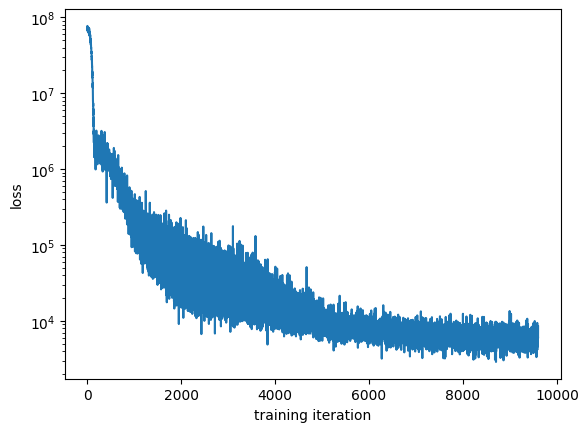

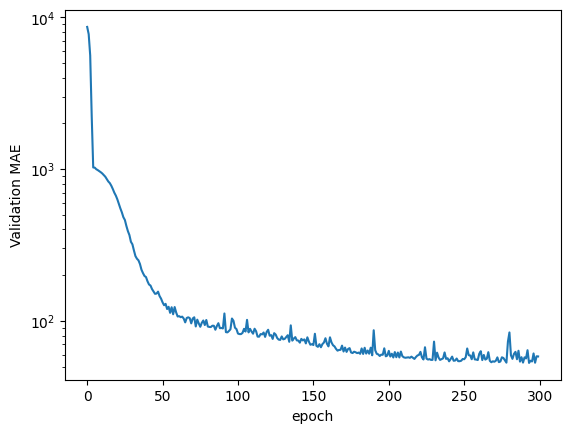

In [ ]:
plt.plot(loss_arr, label='train')
plt.yscale('log')
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.show()
plt.plot(val_loss, label='val')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Validation MAE')
plt.show()